# Multidimensional data analysis

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Make the graphs a bit prettier, and bigger
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])
plt.rcParams['figure.figsize'] = (15, 7)

In [10]:
conn_string_fb = 'mysql://{user}:{password}@{host}:{port}/{db}'.format(
    user='student',
    password='dwdstudent2015',
    host='db.ipeirotis.org',
    port=3306,
    db='facebook')
engine_fb = create_engine(conn_string_fb)

## Multidimesnional data analysis: From raw counts to percentages

Now let's run a query to get the political views of Facebook users, broken down by gender.

In [11]:
polviews_by_gender = '''
SELECT Sex, PoliticalViews, COUNT(*) AS cnt 
FROM Profiles 
WHERE Sex IS NOT NULL AND PoliticalViews IS NOT NULL 
GROUP BY Sex, PoliticalViews
ORDER BY  PoliticalViews, Sex
'''

And let's get the dataframe:

In [12]:
df = pd.read_sql(polviews_by_gender, con=engine_fb)
df

,Sex,PoliticalViews,cnt
0,Female,Apathetic,309
1,Male,Apathetic,462
2,Female,Conservative,428
3,Male,Conservative,474
4,Female,Liberal,4054
5,Male,Liberal,2196
6,Female,Libertarian,113
7,Male,Libertarian,196
8,Female,Moderate,1444
9,Male,Moderate,1379


In [13]:
df.dtypes

Sex               object
PoliticalViews    object
cnt                int64
dtype: object

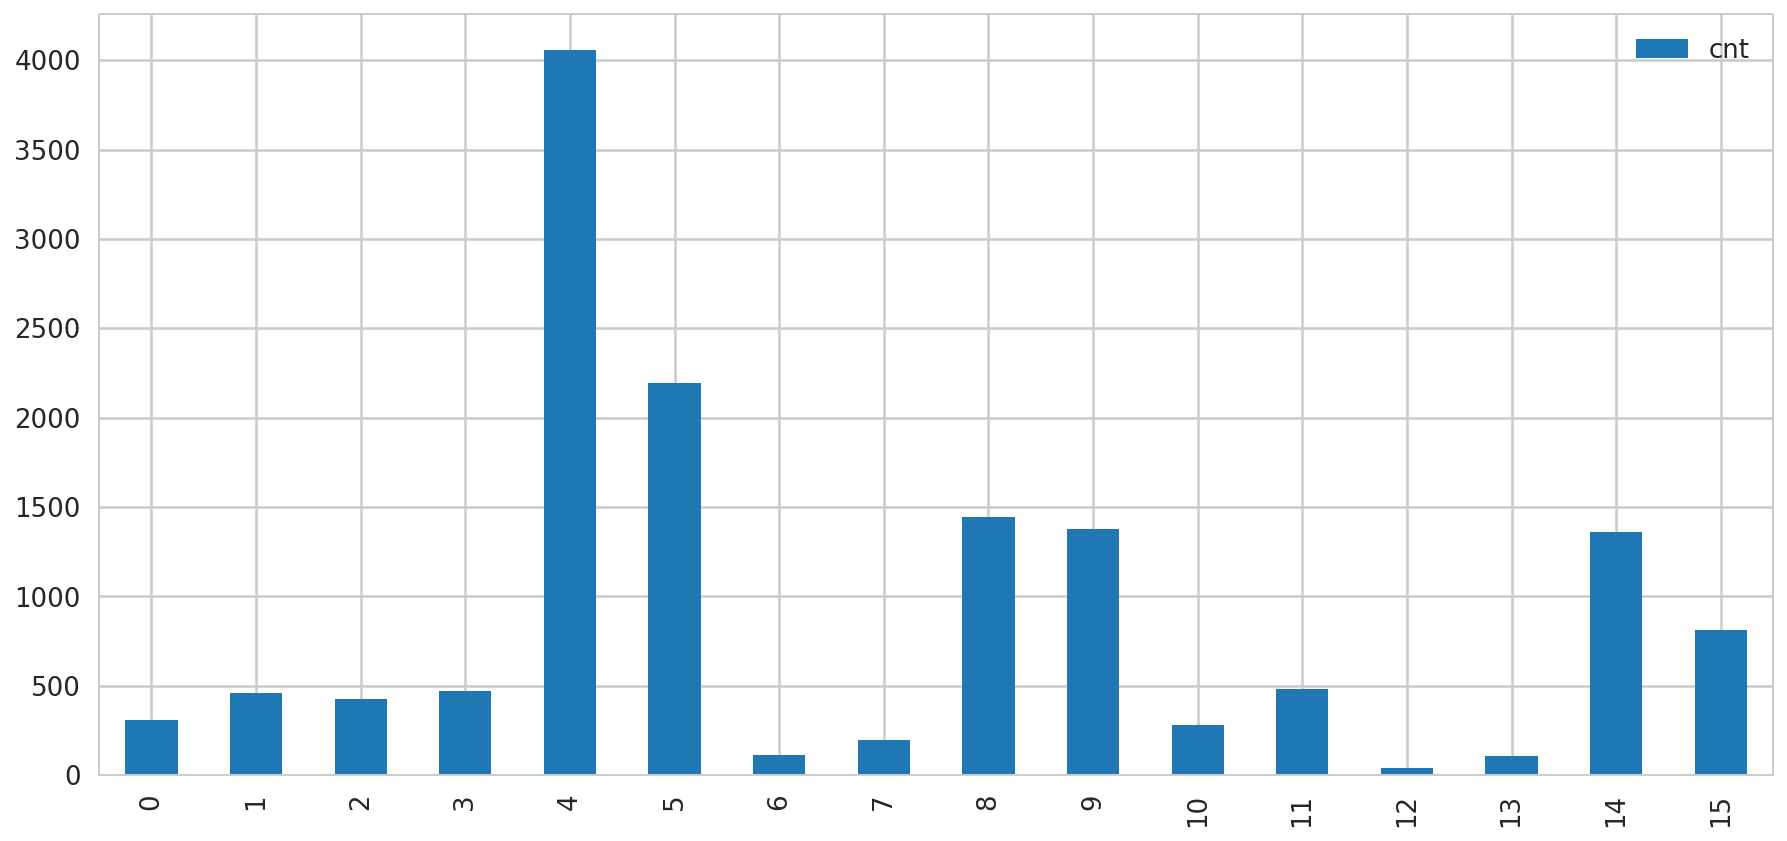

In [14]:
# Let's plot this!
# Bleh, this is ugly...
# Remember that the index of the dataframe becomes the default x-axis
df.plot(kind='bar')

In [15]:
# Pivot, baby!
# Now the index contains the Political Views, which will be our x-axis
dfp = pd.pivot_table(data = df, index='PoliticalViews', columns='Sex', values='cnt', aggfunc='sum')
dfp

Sex,Female,Male
PoliticalViews,,
Apathetic,309,462
Conservative,428,474
Liberal,4054,2196
Libertarian,113,196
Moderate,1444,1379
Other,280,482
Very Conservative,38,107
Very Liberal,1362,813


We will now convert the PoliticalViews column into an **ordered Categorical variable**. This is not strictly necessary, but it will be useful later.
 It ensures that Political Views appear in an order according to their political spectrum, as opposed to alphabetical.

In [18]:
df.PoliticalViews = pd.Categorical(df.PoliticalViews,
    categories = ['Very Liberal', 'Liberal', 'Moderate', 'Conservative', 'Very Conservative', 'Libertarian', 'Apathetic', 'Other'], 
    ordered=True
)

dfp = pd.pivot_table(data = df, index='PoliticalViews', columns='Sex', values='cnt', aggfunc='sum')
dfp

Sex,Female,Male
PoliticalViews,,
Very Liberal,1362,813
Liberal,4054,2196
Moderate,1444,1379
Conservative,428,474
Very Conservative,38,107
Libertarian,113,196
Apathetic,309,462
Other,280,482


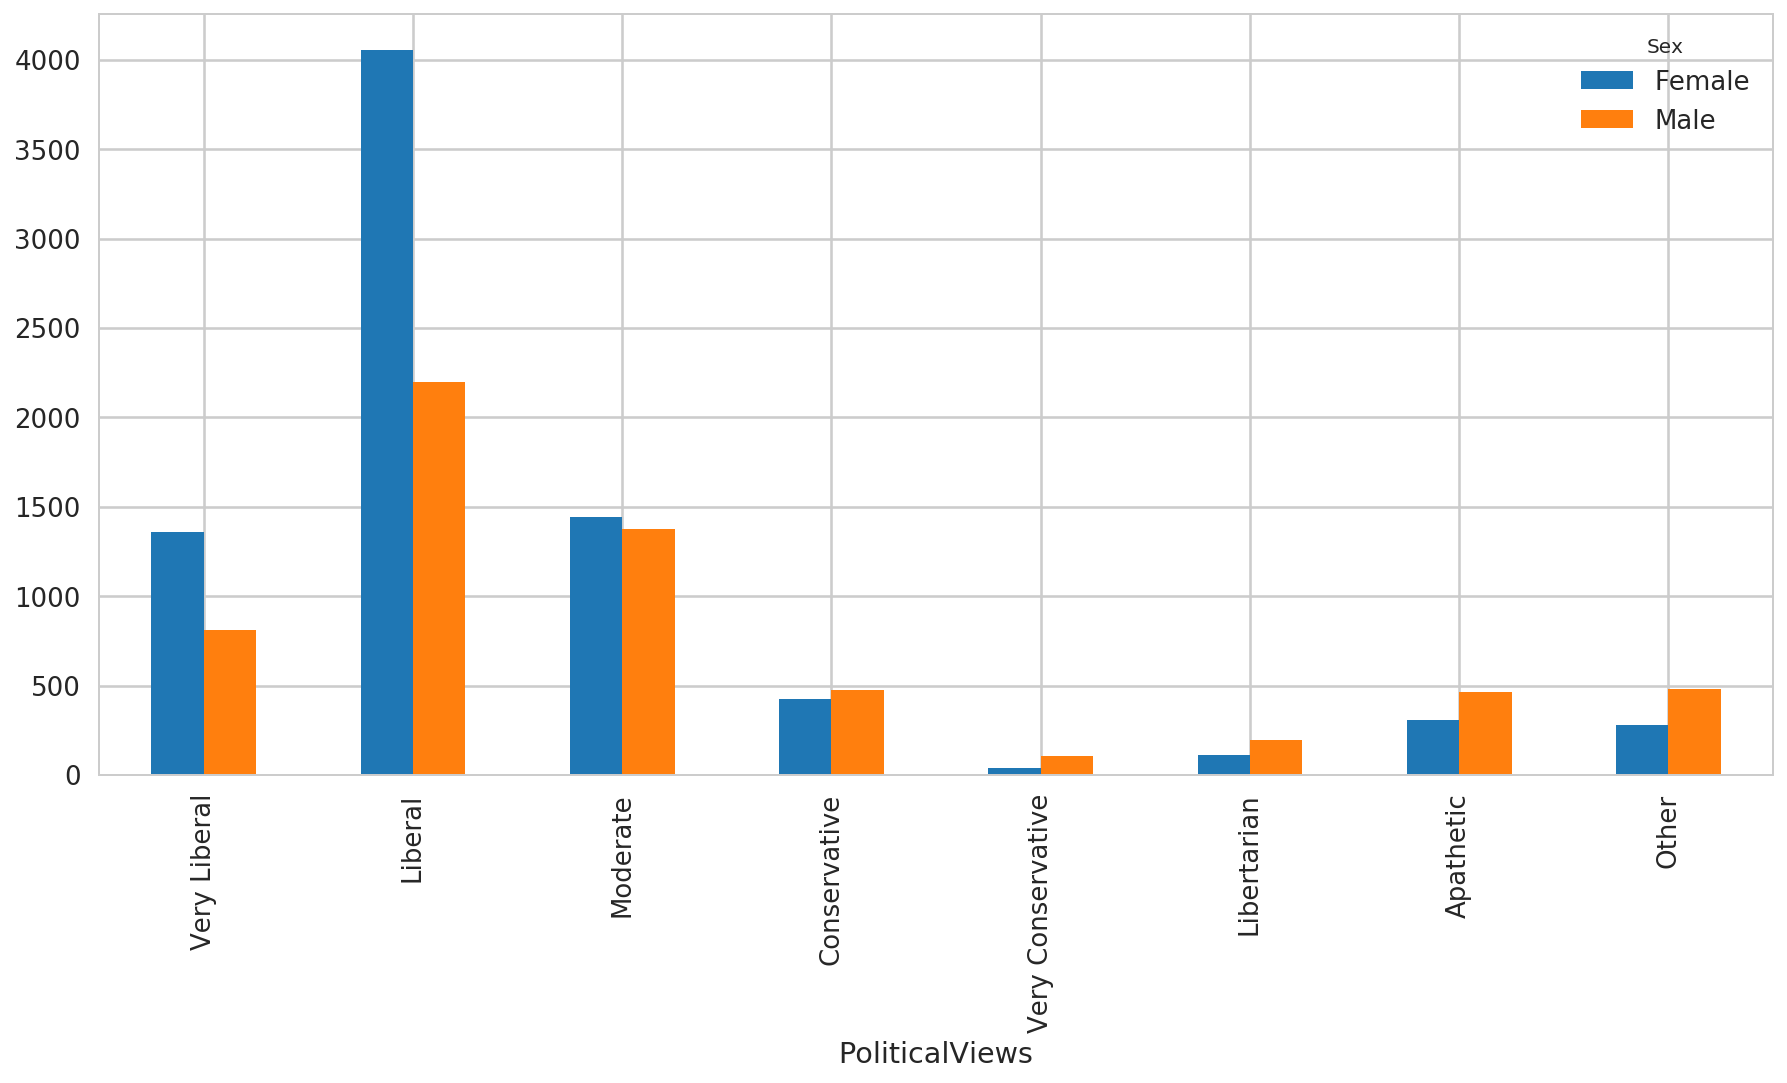

In [19]:
dfp.plot(kind='bar')

## Normalizing values: From raw counts to percentages

Now, let's see a bit how we can normalize the values in Pandas, by performing operations on the columns and rows.

In [60]:
dfp

Sex,Female,Male
PoliticalViews,,
Very Liberal,1362,813
Liberal,4054,2196
Moderate,1444,1379
Conservative,428,474
Very Conservative,38,107
Libertarian,113,196
Apathetic,309,462
Other,280,482


In [20]:
# the .T is a shortcut for .transpose()
# and returns the transposed table
dfp.T

PoliticalViews,Very Liberal,Liberal,Moderate,Conservative,Very Conservative,Libertarian,Apathetic,Other
Sex,,,,,,,,
Female,1362,4054,1444,428,38,113,309,280
Male,813,2196,1379,474,107,196,462,482


In [61]:
# sums the columns
dfp.sum() 

# Equivalent commands:
# dfp.sum(axis='index')  # summing 'across the index'
# dfp.sum(axis=0)        # axis=0 is equivalent to summing axis='index'

Sex
Female    8028
Male      6109
dtype: int64

In [63]:
# Summing the transpose is same as 
# summing the rows of the original
dfp.T.sum()

# Equivalent commands
# dfp.sum(axis='columns') 
# dfp.sum(axis=1)

PoliticalViews
Very Liberal         2175
Liberal              6250
Moderate             2823
Conservative          902
Very Conservative     145
Libertarian           309
Apathetic             771
Other                 762
dtype: int64

In [33]:
# Let's normalize the columns, as we have more females than males, and it seems that there are always more women
dfp_norm = dfp / dfp.sum()
# Columns (ie Sex) sum up to 1
dfp_norm

Sex,Female,Male
PoliticalViews,,
Very Liberal,0.169656,0.133082
Liberal,0.504983,0.359470
Moderate,0.179870,0.225733
Conservative,0.053313,0.077590
Very Conservative,0.004733,0.017515
Libertarian,0.014076,0.032084
Apathetic,0.038490,0.075626
Other,0.034878,0.078900


In [37]:
# Instead of dfp / dfp.sum(), we can also use the .div() method, for dividing the entries with the sum()
# Note that, by definition, the dfp / dfp.sum() operation divides  column-wise, not row-wise.
# dfp_norm = dfp.div( dfp.sum(), axis='columns' )
# dfp_norm

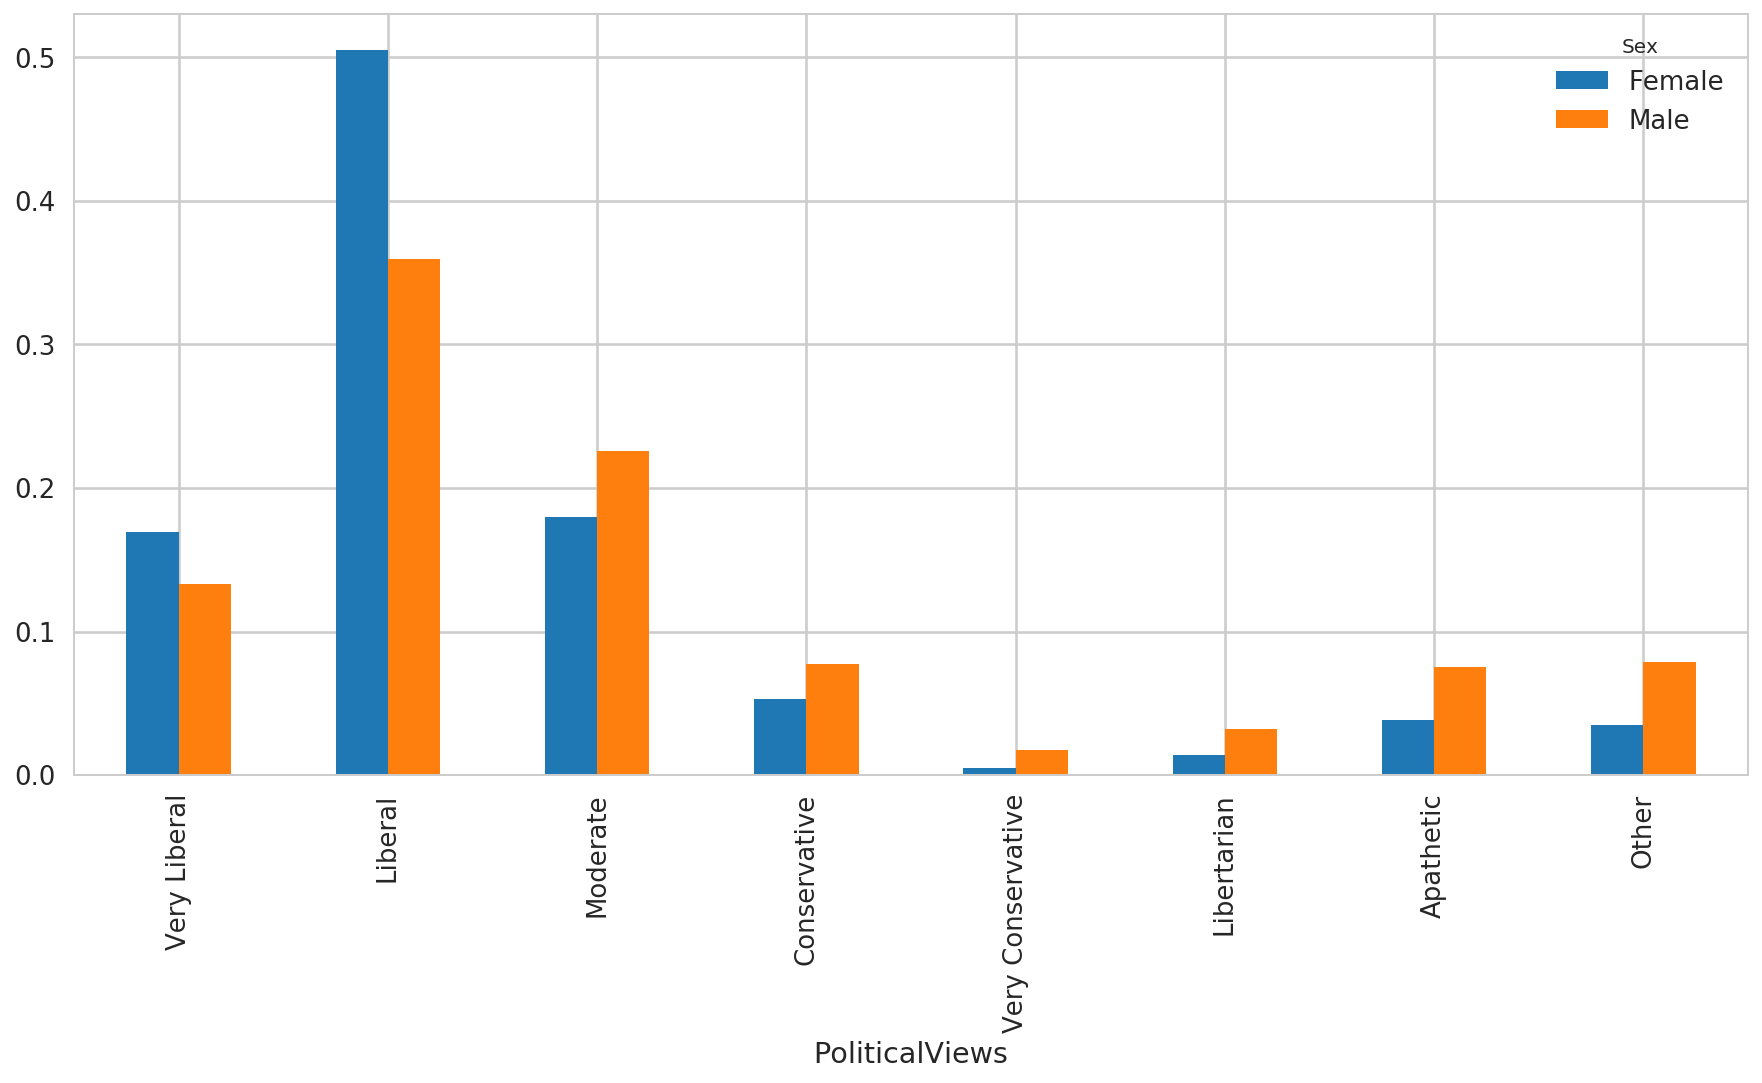

In [38]:
dfp_norm.plot(kind='bar')

In [39]:
# We will now normalize across the rows
dfp_norm2 = dfp.T / dfp.T.sum()
dfp_norm2.T

Sex,Female,Male
PoliticalViews,,
Very Liberal,0.626207,0.373793
Liberal,0.648640,0.351360
Moderate,0.511513,0.488487
Conservative,0.474501,0.525499
Very Conservative,0.262069,0.737931
Libertarian,0.365696,0.634304
Apathetic,0.400778,0.599222
Other,0.367454,0.632546


In [40]:
# Same operation as above, but with the .div() function
# to find the fraction of males/females within each political category
dfp_norm2 = dfp.div( dfp.sum(axis='columns'), axis='index' )
dfp_norm2

Sex,Female,Male
PoliticalViews,,
Very Liberal,0.626207,0.373793
Liberal,0.648640,0.351360
Moderate,0.511513,0.488487
Conservative,0.474501,0.525499
Very Conservative,0.262069,0.737931
Libertarian,0.365696,0.634304
Apathetic,0.400778,0.599222
Other,0.367454,0.632546


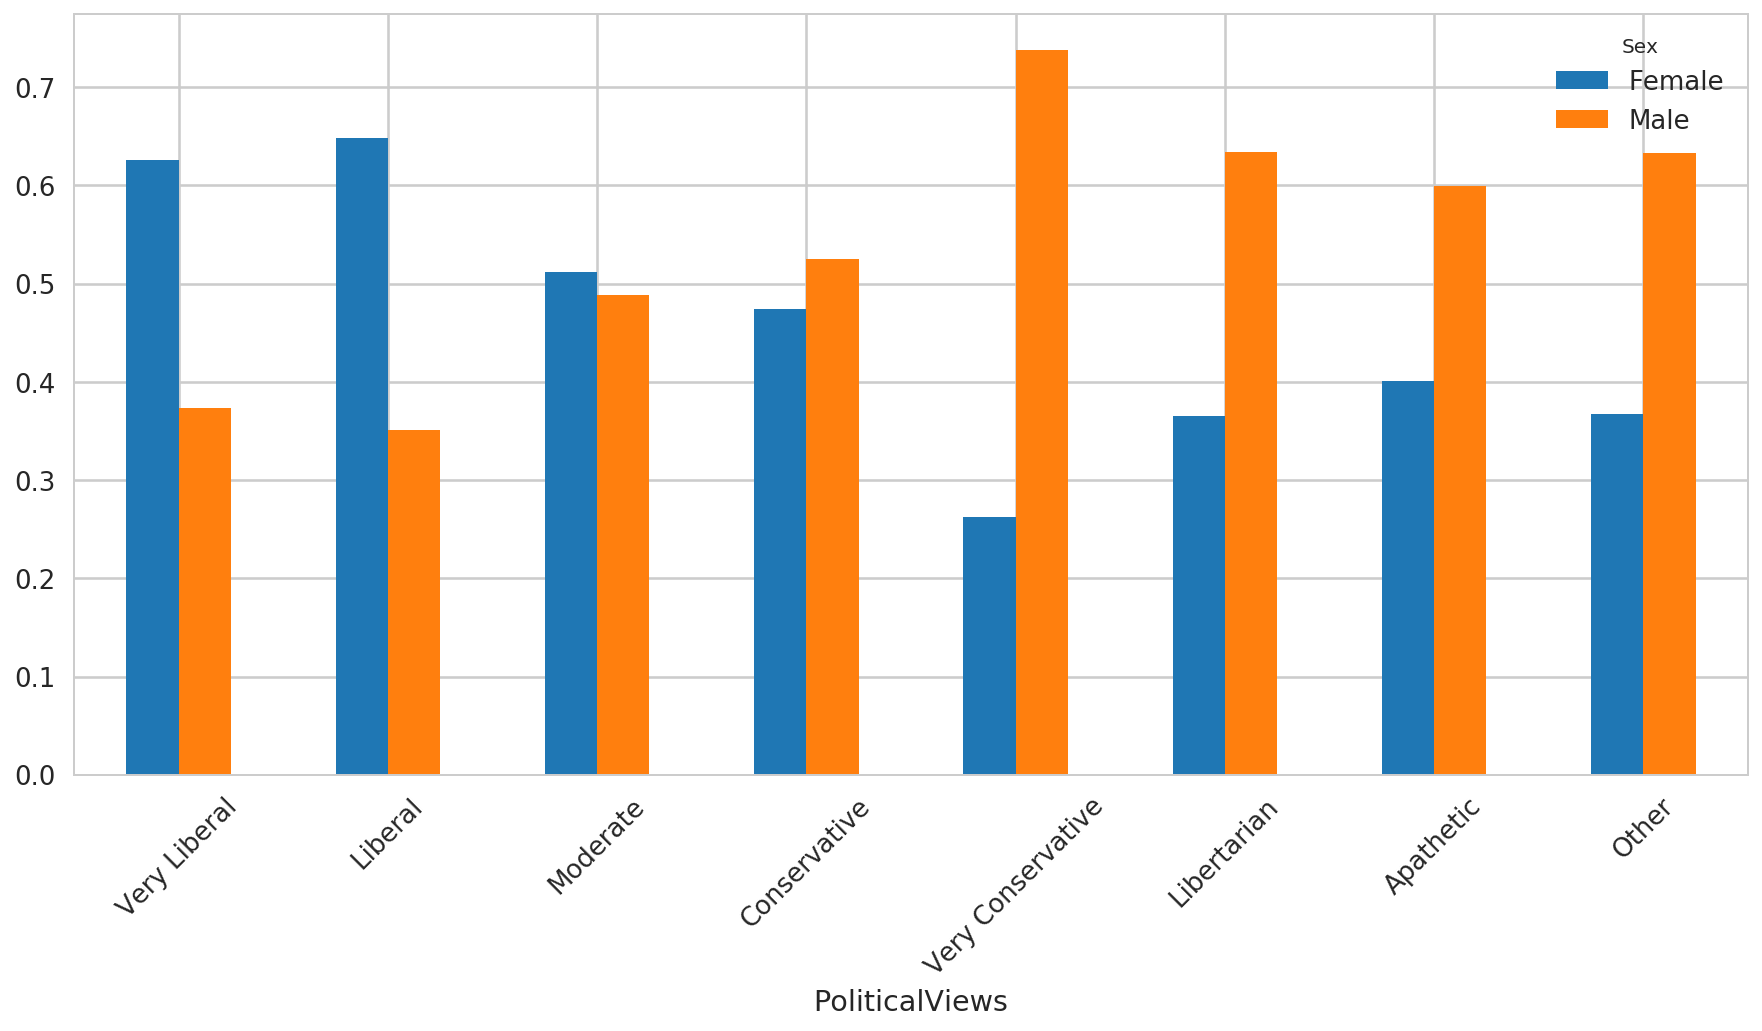

In [42]:
dfp_norm2.plot(kind='bar', rot=45)

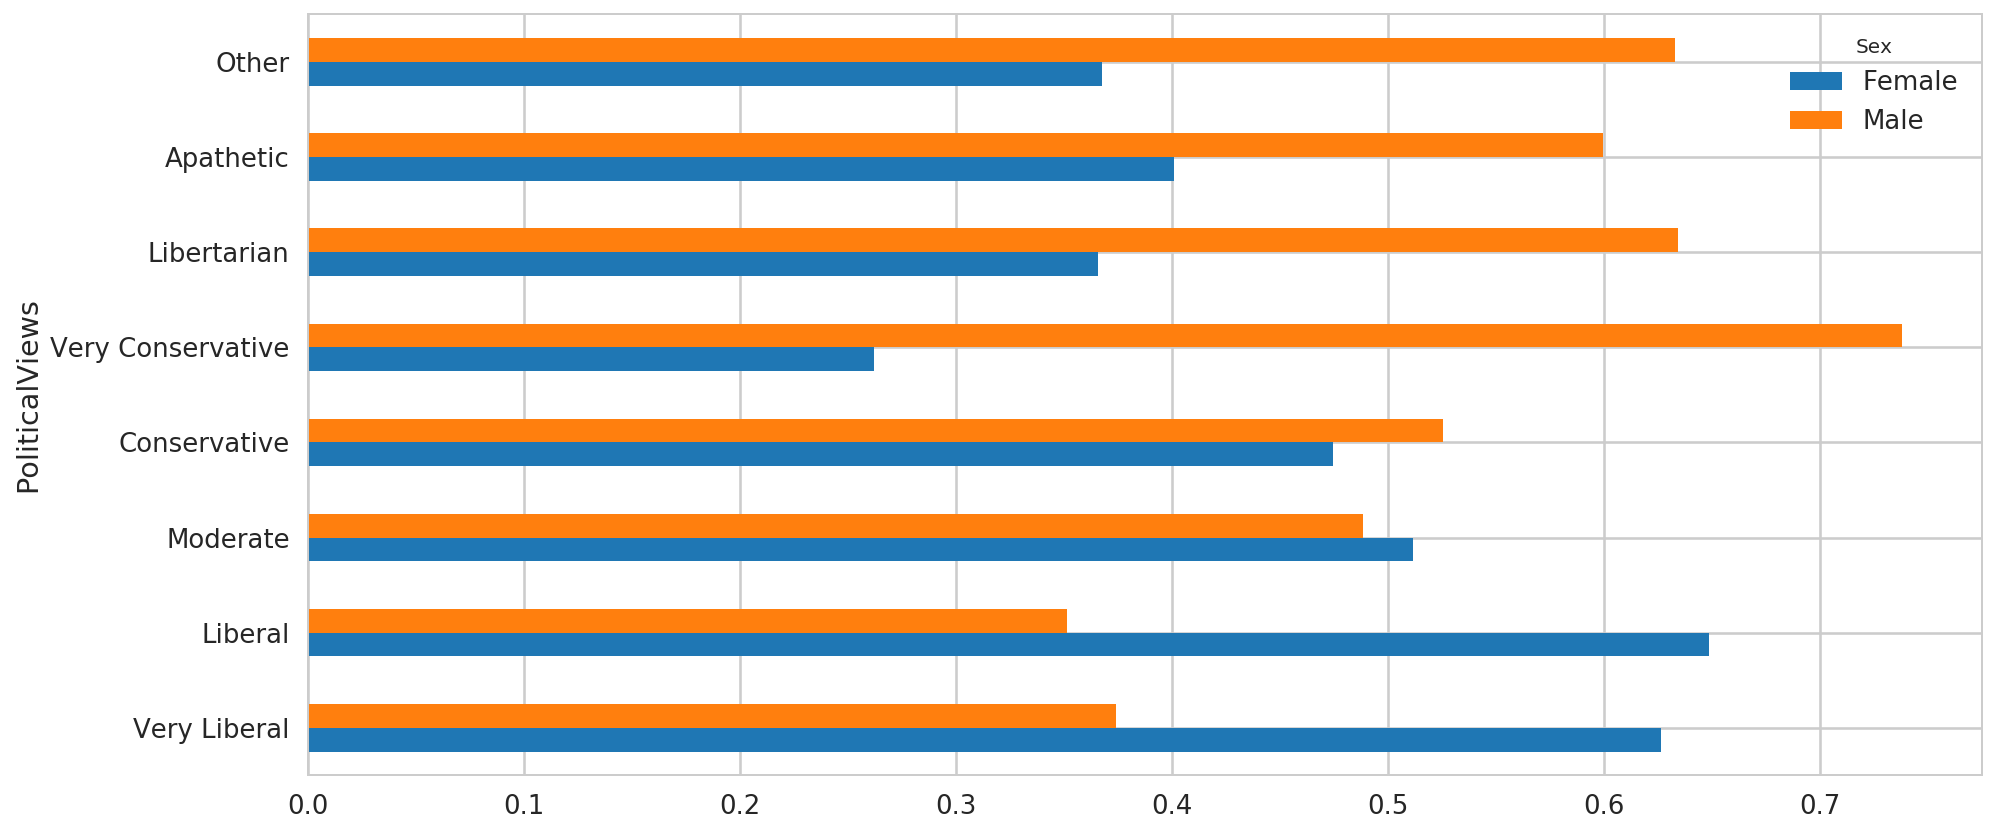

In [41]:
dfp_norm2.plot(kind='barh')

## Exercise on Normalizing Values

a. Use the tables `RelationshipStatus` and `LookingFor`, and show create a plot with a breakdown of what people in different relationship statuses are looking for. To make things more readable (and to practice a bit SQL), remove from the output all combinations that have less than 10 students in them. The plot can use the absolute counts.
 


b. Normalize the results and plot again. To get experience with normalization, try to normalize both by Status (eg "80% of the people who are in a relationship are looking for Friendship") and by Relationship Status (eg "70% of the people who are looking for Random Play are Single").

### Solution (Part a)

In [44]:
query = '''
SELECT R.Status, L.LookingFor, COUNT(*) AS cnt
FROM Relationship R INNER JOIN LookingFor L ON R.ProfileID = L.ProfileID
GROUP BY R.Status, L.LookingFor
HAVING cnt>10
'''
df = pd.read_sql(query, con=engine_fb)
df

,Status,LookingFor,cnt
0,In a Relationship,A Relationship,72
1,In a Relationship,Dating,88
2,In a Relationship,Friendship,2213
3,In a Relationship,Random play,182
4,In a Relationship,Whatever I can get,255
5,In an Open Relationship,A Relationship,74
6,In an Open Relationship,Dating,99
7,In an Open Relationship,Friendship,201
8,In an Open Relationship,Random play,149
9,In an Open Relationship,Whatever I can get,107


In [45]:
pivot = df.pivot_table(
    index='Status',
    columns='LookingFor',
    values='cnt'
)
pivot

LookingFor,A Relationship,Dating,Friendship,Random play,Whatever I can get
Status,,,,,
In a Relationship,72,88,2213,182,255
In an Open Relationship,74,99,201,149,107
Married,210,286,793,231,248
Single,1706,2177,3453,1373,1357


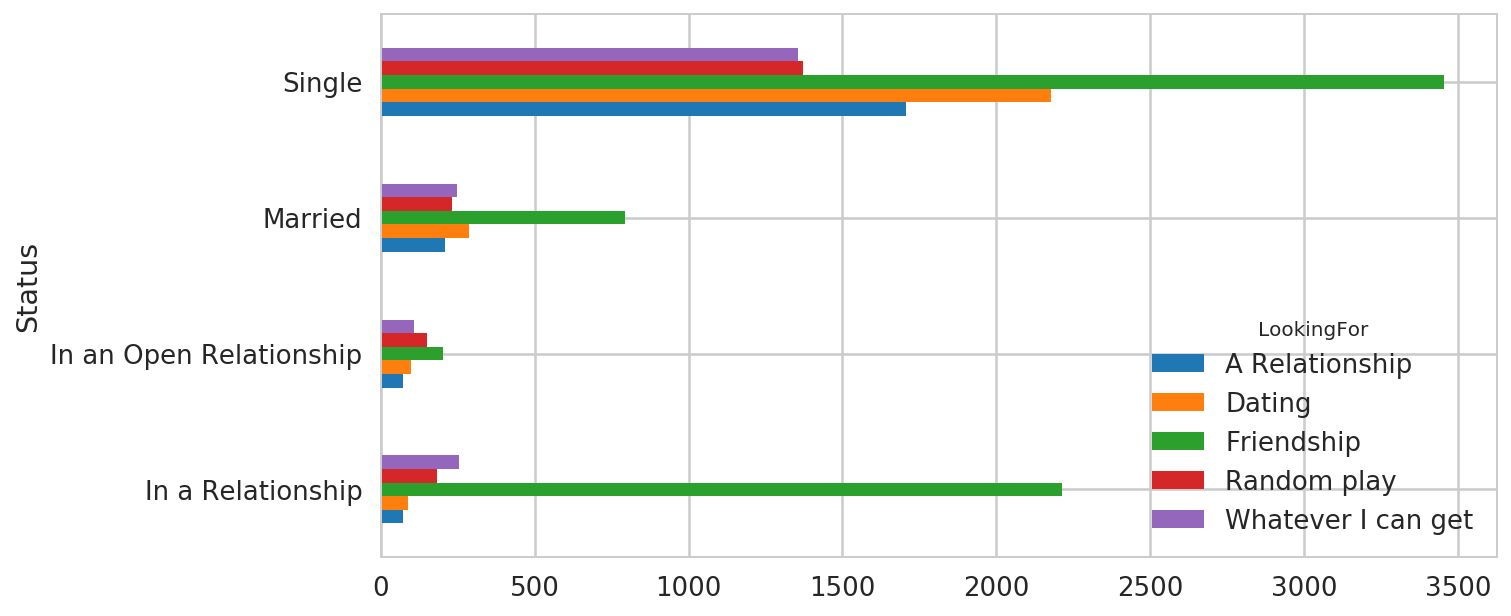

In [46]:
# Raw numbers, by relationship status
pivot.plot(kind='barh', figsize=(10,5))

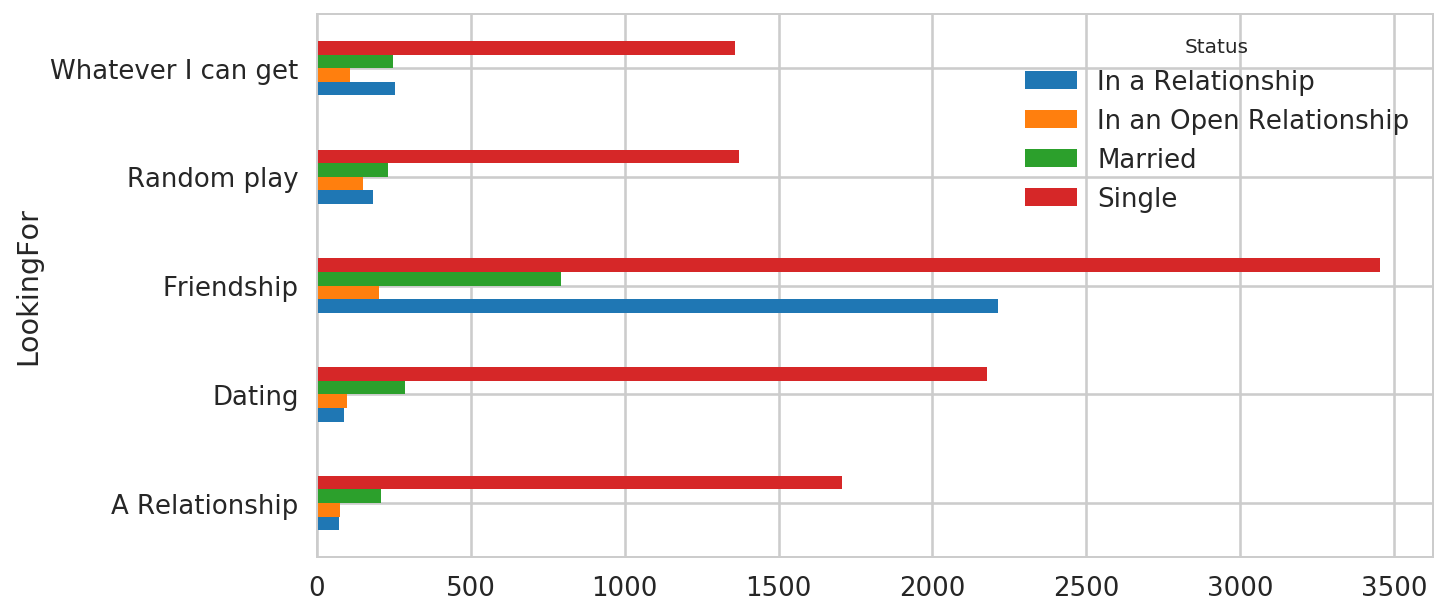

In [47]:
# Raw numbers, by looking for (taking the transpose)
pivot.T.plot(kind='barh', figsize=(10,5))

In [52]:
# Every column (LookingFor) sums up to 1
normed1 = pivot / pivot.sum()
normed1

LookingFor,A Relationship,Dating,Friendship,Random play,Whatever I can get
Status,,,,,
In a Relationship,0.034918,0.033208,0.332282,0.094057,0.129639
In an Open Relationship,0.035887,0.037358,0.030180,0.077003,0.054398
Married,0.101843,0.107925,0.119069,0.119380,0.126080
Single,0.827352,0.821509,0.518468,0.709561,0.689883


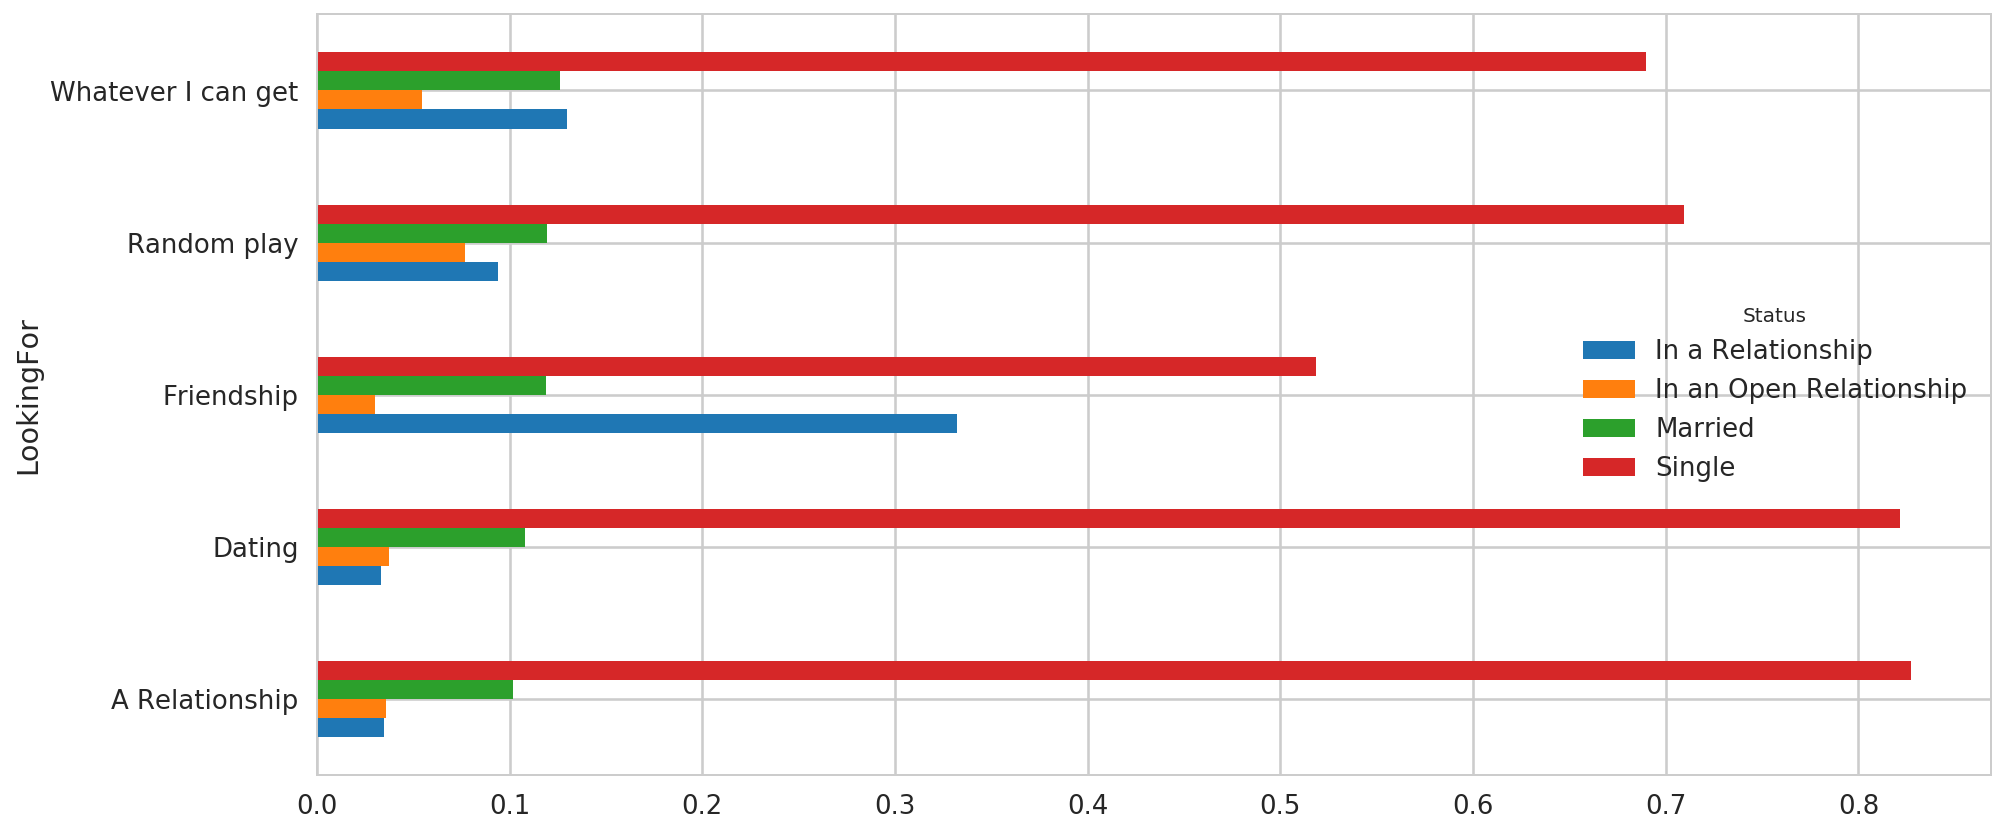

In [56]:
# For every LookingFor value, show the breakdown among relationship statuses
normed1.T.plot.barh()

In [58]:
# Every column (Status) sums up to 1
normed2 = (pivot.T / pivot.T.sum())
normed2

Status,In a Relationship,In an Open Relationship,Married,Single
LookingFor,,,,
A Relationship,0.025623,0.117460,0.118778,0.169481
Dating,0.031317,0.157143,0.161765,0.216273
Friendship,0.787544,0.319048,0.448529,0.343036
Random play,0.064769,0.236508,0.130656,0.136400
Whatever I can get,0.090747,0.169841,0.140271,0.134810


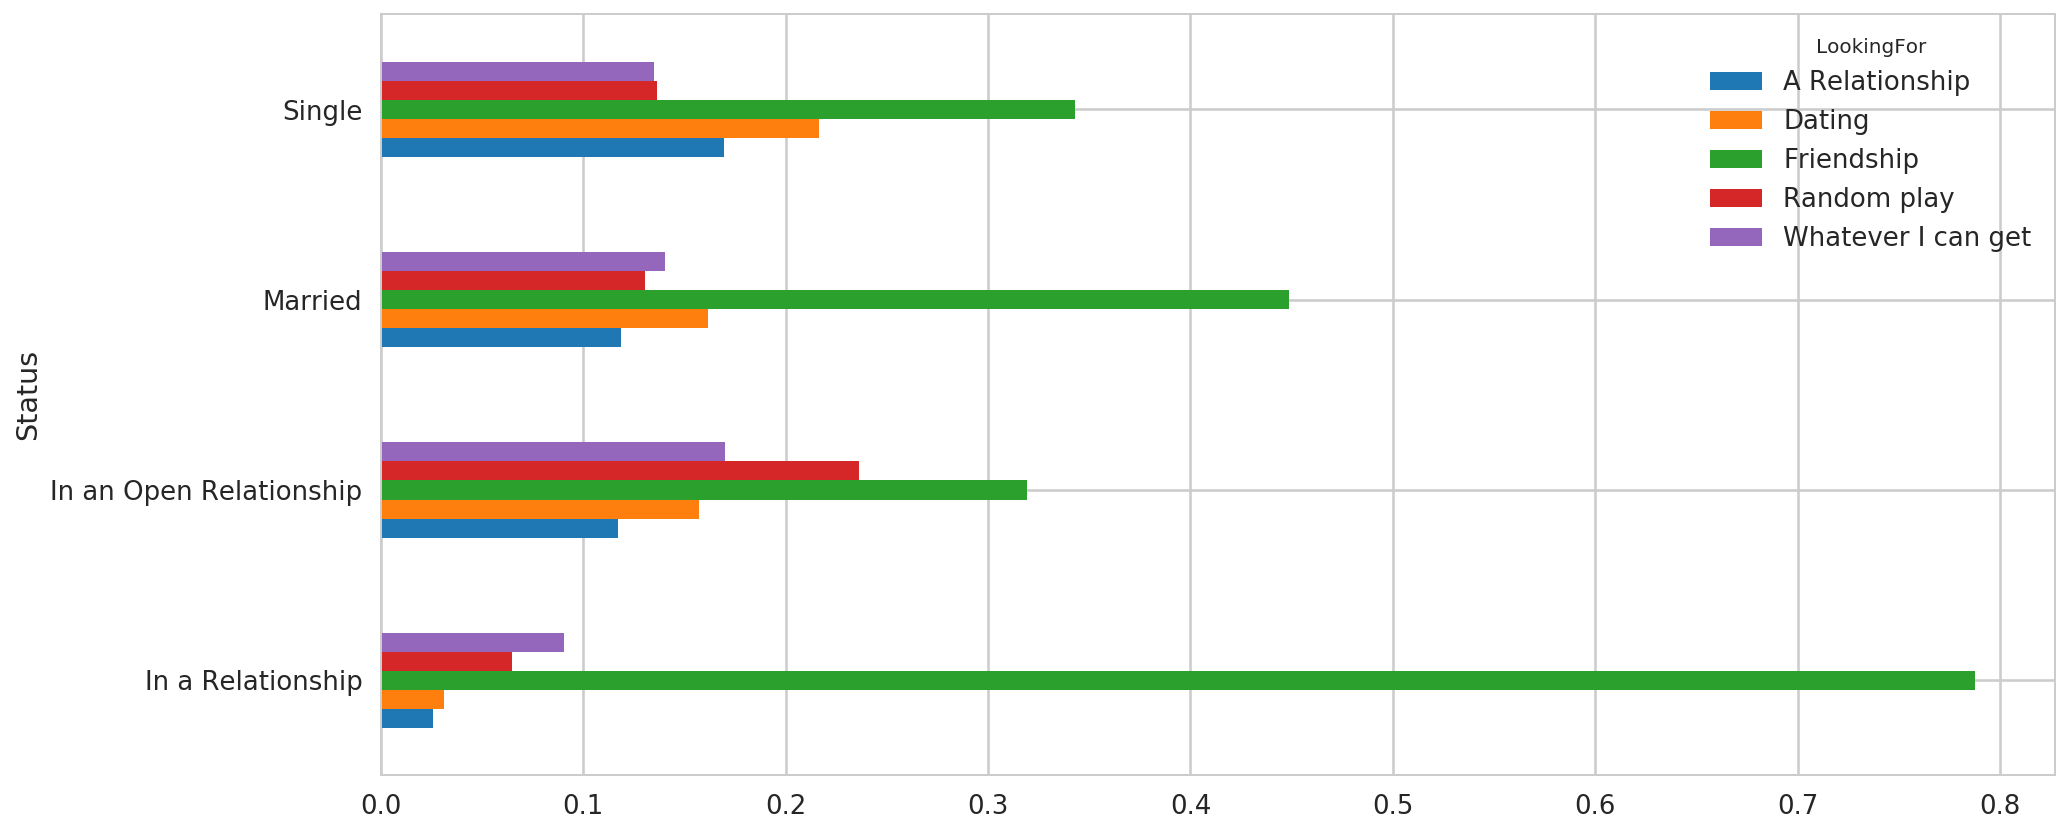

In [60]:
# For every relationship status, show the breakdown among "LookingFor" values
normed2.T.plot.barh()

### Facebook, Favorite Books, and Political views

Now let's do an analysis that examines book preferences and how they correlated with political leanings.

We will start by fetching the favorite books for students that declared themselves as Liberal or Conservative.

In [ ]:
books = '''
SELECT B.Book, P.PoliticalViews, COUNT(*) AS cnt 
FROM Profiles P JOIN FavoriteBooks B ON B.ProfileID = P.ProfileId  
WHERE PoliticalViews IS NOT NULL AND B.Book IS NOT NULL 
      AND (PoliticalViews = 'Liberal' OR PoliticalViews = 'Conservative')
AND B.Book IN (
    SELECT Book 
    FROM FavoriteBooks B JOIN Profiles P ON B.ProfileID = P.ProfileId  
    WHERE (P.PoliticalViews = 'Liberal' OR P.PoliticalViews = 'Conservative')
    GROUP BY Book HAVING COUNT(DISTINCT P.ProfileID)>10
)
GROUP BY B.Book, P.PoliticalViews;
'''

In [ ]:
df_books = pd.read_sql(books, con=engine_fb)
df_books.head(10)

In [ ]:
len(df_books)

In [ ]:
dfp = df_books.pivot_table(
    index='Book', 
    columns='PoliticalViews', 
    values='cnt')
dfp.head(10)

Notice the `NaN` values for the entries where we had no users falling into that group. Since we will want to do calculations for these books as well, we will use the `fillna` command to fill these entries with a default value (in our case, 0)

In [ ]:
# Fill the NaN entries with the value 0 
dfp = df_books.pivot_table(
    index='Book', 
    columns='PoliticalViews', 
    values='cnt').fillna(0)
dfp.head(10)

**Normalization**: We now want to normalize the entries before proceeding further. Let's take a look at the breakdown of political views in the database.

In [ ]:
polviews = '''
SELECT PoliticalViews, COUNT(*) AS cnt 
FROM facebook.Profiles
GROUP BY PoliticalViews
'''

In [ ]:
df_polviews = pd.read_sql(polviews, con=engine_fb)
df_polviews

Since we have many more conservatives than liberals, let's create a new column that calculates the **percentage** of liberal and conservative students that liked each book. For simplicity, we just enter directly the values 6461 (number of liberals) and 936 (number of conservatives). We add the `+1` in the numerator to avoid division by zero later on. _As practice, try to fetch the values 936 and 6461 directly from the database, and automate the calculation._

In [ ]:
dfp["Liberal_perc"] = (dfp["Liberal"] +1)  / 6461
dfp["Conservative_perc"] = (dfp["Conservative"] +1)  / 936

In [ ]:
dfp

#### Lift

Now that we have the normalized values, we can compute the **lift** for each book. The lift is the ratio between the percentage of liberals and the percentage of convervatives. A book with `lift==1` will be equally read by both conservatives and liberals. Books that have lifts significantly higher or lower than 1, reveal preferences to be read by one side of the political spectrum.

In [ ]:
dfp["lift_liberal"] = dfp["Liberal_perc"] / dfp["Conservative_perc"]
dfp["lift_conservative"] = dfp["Conservative_perc"]  / dfp["Liberal_perc"]

In [ ]:
dfp

#### Log-odds

One common tranformation is to take the `log` of the lift. We call this metric **log odds**. In that case, the `lift==1` corresponds to a `log_odds` of 0. Negative values indicate negative association, and positive values indicate positive association. A nice property of log-odds is that they are **additive**, which means that summing up log-odds makes (mathematical) sense, under some reasonably general conditions. (The details are beyond the scope of this course, but you can learn more in the data mining class.)

In [ ]:
import numpy as np
dfp["log_odds_liberal"]      =  np.log(dfp["lift_liberal"])
dfp["log_odds_conservative"] =  np.log(dfp["lift_conservative"])

In [ ]:
show_columns = ["lift_liberal", "log_odds_liberal", "lift_conservative", "log_odds_conservative", "Liberal", "Conservative"]

In [ ]:
liberal_books = (dfp[show_columns]
                 .sort_values("lift_liberal", ascending=False)
                 .head(10)
                )
liberal_books

In [ ]:
conservative_books = (dfp[show_columns]
                      .sort_values("lift_conservative", ascending=False)
                      .head(10)
                     )
conservative_books

In [ ]:
plot = conservative_books.lift_conservative.plot(kind='barh', figsize=(15,5))
plot.set_xlabel("Lift for Conservatives")

In [ ]:
plot = liberal_books.lift_liberal.plot(kind='barh', figsize=(15,5))
plot.set_xlabel("Lift for Liberals")

#### Exercise

We have seen how to compute the log-odds between liberal-conservative for each book. Given this information, we can try to estimate political leanings of students. You can do this by summing the log-odds of their favorite books. 

Steps: 
1. Create a table with the log-odds of the books. 
2. Join the table with the log-odds with the book preferences table.
3. Sum the log-odds score for each student.

Evaluation:
* You have students that have declared their political preferences as Liberal, Conservative, Very Liberal, Very Conservative. Examine the scores for these students, to check how well this technique works. The simplest way is to compute the average (mean) log-odds for students that fall into the different groups. Alternatively, you can try to plot the full distribution of scores.
* Calculate a score for each student that did not declare a political view but has listed Favorite Books.

Notes: 
* You can do the work in MySQL or in Pandas. If you decide to work purely in Pandas, the [`merge`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html#pandas.DataFrame.merge) command allows you to perform joins between dataframes, in way similar to SQL.